In [7]:
import pandas as pd

In [8]:
file_path_h = "/Users/numan/Desktop/Milestone 1/milestone-one/src/data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility_20240114.csv"
file_path_c = "/Users/numan/Desktop/Milestone 1/milestone-one/src/data/Weekly_United_States_COVID-19_Cases_and_Deaths_by_County_-_ARCHIVED_20240113.csv"
hospital_df = pd.read_csv(file_path_h)
covid_df = pd.read_csv(file_path_c)

/var/folders/9m/3n1wq0l97pgc3qn83dw9hqs80000gn/T/ipykernel_11817/53802906.py:3: DtypeWarning: Columns (0,3,108) have mixed types. Specify dtype option on import or set low_memory=False.
  hospital_df = pd.read_csv(file_path_h)


In [9]:
for column in hospital_df.columns:
    if pd.api.types.is_numeric_dtype(hospital_df[column]):
        # Skip the conversion to 'Int64' if the column is already in a float dtype that can contain NaN
        if not pd.api.types.is_float_dtype(hospital_df[column]):
            try:
                hospital_df[column] = hospital_df[column].astype('Int64')
            except TypeError:
                print(f"Cannot convert column {column} due to incompatible data.")


In [10]:
columns_of_interest = [
    'collection_week', 
    'total_beds_7_day_avg',
    'total_beds_7_day_sum', 
    'inpatient_beds_used_covid_7_day_avg',
    'inpatient_beds_used_covid_7_day_sum',
    'total_icu_beds_7_day_avg', 
    'staffed_adult_icu_bed_occupancy_7_day_avg', 
    'state', 
    'city', 
    'zip', 
    'is_metro_micro', 
    'fips_code'
]

hospital_df = hospital_df[columns_of_interest]

In [11]:
# Convert 'collection_week' and 'date' to datetime
hospital_df['collection_week'] = pd.to_datetime(hospital_df['collection_week'], errors='coerce')
covid_df['date'] = pd.to_datetime(covid_df['date'], errors='coerce')


In [12]:
# Extract the week and year from the date
hospital_df['year'] = hospital_df['collection_week'].dt.isocalendar().year
hospital_df['week'] = hospital_df['collection_week'].dt.isocalendar().week

covid_df['year'] = covid_df['date'].dt.isocalendar().year
covid_df['week'] = covid_df['date'].dt.isocalendar().week


In [13]:

covid_weekly = covid_df.groupby(['fips_code', 'year', 'week']).agg({
    'New cases': 'sum',
    'New deaths': 'sum',
    'cumulative_cases': 'max',
    'cumulative_deaths': 'max'
}).reset_index()

In [14]:
merged_df = pd.merge(
    hospital_df, 
    covid_weekly, 
    on=['fips_code', 'year', 'week'], 
    how='inner'
)

In [15]:
merged_df.head()

,collection_week,total_beds_7_day_avg,total_beds_7_day_sum,inpatient_beds_used_covid_7_day_avg,inpatient_beds_used_covid_7_day_sum,total_icu_beds_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,state,city,zip,is_metro_micro,fips_code,year,week,New cases,New deaths,cumulative_cases,cumulative_deaths
0,2020-04-26,NaN,NaN,NaN,NaN,7.0,NaN,AL,ENTERPRISE,36330.0,1,1031.0,2020,17,33,0,77,0
1,2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,CA,LANCASTER,93534.0,1,6037.0,2020,26,13386,210,88458,3152
2,2020-04-26,NaN,NaN,5.5,22.0,8.0,NaN,CA,TRACY,95376.0,1,6077.0,2020,17,167,3,450,20
3,2020-05-10,168.7,1181.0,19.9,139.0,40.0,NaN,CT,MERIDEN,6450.0,1,9009.0,2020,19,1274,136,8469,629
4,2020-05-03,NaN,NaN,0.0,0.0,0.0,NaN,CT,BRANFORD,6405.0,1,9009.0,2020,18,1568,148,7195,493


In [16]:
new_column_order = ['city', 'state', 'zip'] + [col for col in merged_df.columns if col not in ['city', 'county', 'state', 'zip']]

# Reassign the DataFrame with the new column order
merged_df = merged_df[new_column_order]

In [17]:
merged_df.head()

,city,state,zip,collection_week,total_beds_7_day_avg,total_beds_7_day_sum,inpatient_beds_used_covid_7_day_avg,inpatient_beds_used_covid_7_day_sum,total_icu_beds_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,is_metro_micro,fips_code,year,week,New cases,New deaths,cumulative_cases,cumulative_deaths
0,ENTERPRISE,AL,36330.0,2020-04-26,NaN,NaN,NaN,NaN,7.0,NaN,1,1031.0,2020,17,33,0,77,0
1,LANCASTER,CA,93534.0,2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,1,6037.0,2020,26,13386,210,88458,3152
2,TRACY,CA,95376.0,2020-04-26,NaN,NaN,5.5,22.0,8.0,NaN,1,6077.0,2020,17,167,3,450,20
3,MERIDEN,CT,6450.0,2020-05-10,168.7,1181.0,19.9,139.0,40.0,NaN,1,9009.0,2020,19,1274,136,8469,629
4,BRANFORD,CT,6405.0,2020-05-03,NaN,NaN,0.0,0.0,0.0,NaN,1,9009.0,2020,18,1568,148,7195,493


In [18]:
columns_to_check = [
    'inpatient_beds_used_covid_7_day_avg', 
    'total_icu_beds_7_day_avg', 
    'staffed_adult_icu_bed_occupancy_7_day_avg'
]

# Filter the DataFrame to remove rows where any of the specified columns have negative values
merged_df = merged_df[
    (merged_df[columns_to_check] >= 0).all(axis=1)
]

In [19]:
columns_to_round = [
    'total_beds_7_day_avg', 
    'inpatient_beds_used_covid_7_day_avg', 
    'total_icu_beds_7_day_avg', 
    'staffed_adult_icu_bed_occupancy_7_day_avg'
]

merged_df[columns_to_round] = merged_df[columns_to_round].round(2)

In [20]:
merged_df['zip'] = merged_df['zip'].astype(int)
merged_df['fips_code'] = merged_df['fips_code'].astype(int)

In [21]:
merged_df.head()

,city,state,zip,collection_week,total_beds_7_day_avg,total_beds_7_day_sum,inpatient_beds_used_covid_7_day_avg,inpatient_beds_used_covid_7_day_sum,total_icu_beds_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,is_metro_micro,fips_code,year,week,New cases,New deaths,cumulative_cases,cumulative_deaths
188,SEWARD,NE,68434,2020-09-27,NaN,NaN,0.0,0.0,0.0,0.0,1,31159,2020,39,28,0,247,4
391,ATHENS,AL,35611,2020-09-06,107.0,749.0,7.9,55.0,10.0,7.9,1,1083,2020,36,92,1,1764,15
1119,SAHUARITA,AZ,85629,2022-10-09,NaN,NaN,0.0,0.0,0.0,0.0,1,4019,2022,40,746,8,292232,4008
1340,COLUMBUS,OH,43215,2020-07-12,NaN,NaN,23.3,140.0,45.0,43.0,1,39049,2020,28,1541,16,10879,371
1500,STUTTGART,AR,72160,2021-10-03,34.0,238.0,0.0,0.0,0.0,0.0,0,5001,2021,39,37,0,3249,58


In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


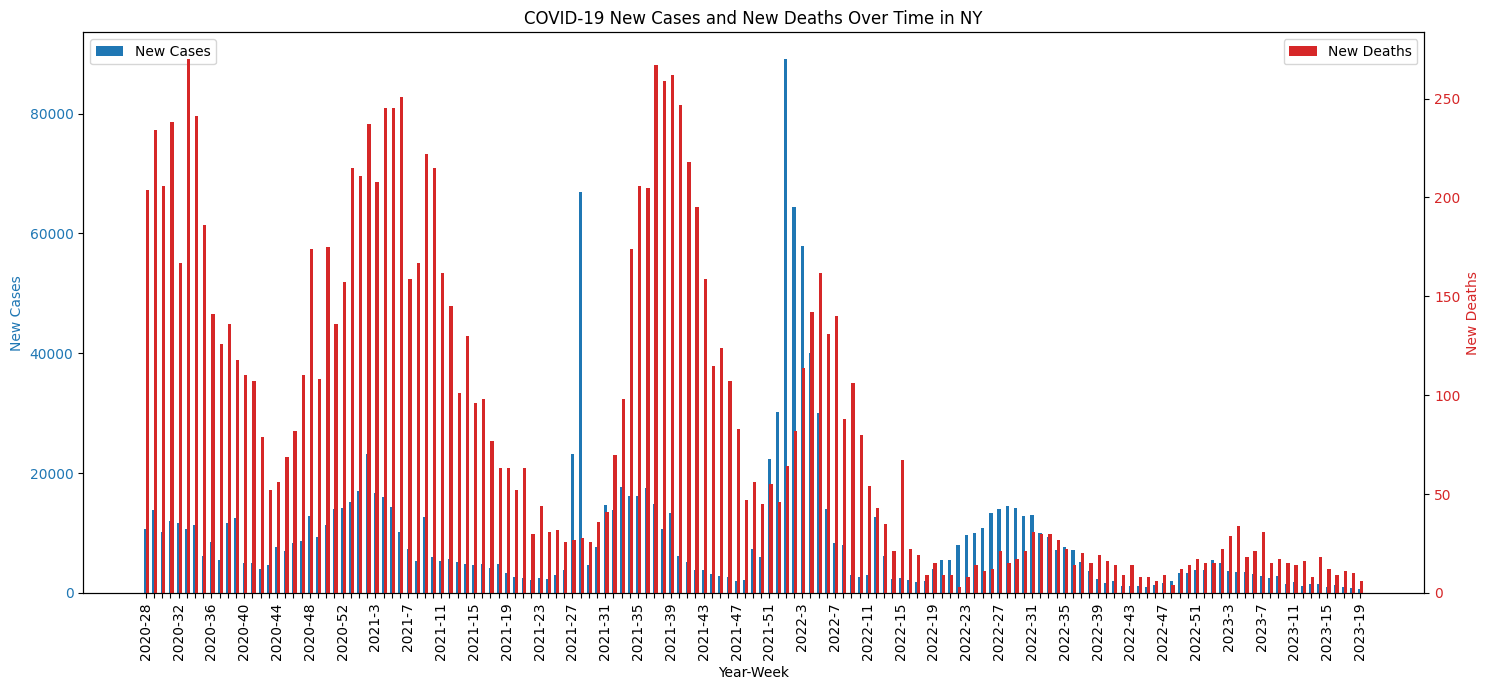

In [23]:
# Assuming you have already filtered and sorted ny_data by 'NY'
ny_data = merged_df[merged_df['state'] == 'TX'].sort_values(['year', 'week'])

# Generating a unique identifier for each week by combining year and week number
ny_data['year_week'] = ny_data['year'].astype(str) + '-' + ny_data['week'].astype(str)

# Create a new figure and a subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 'New cases' on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('New Cases', color=color)
ax1.bar(ny_data['year_week'], ny_data['New cases'], color=color, label='New Cases', width=0.4, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'New deaths'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('New Deaths', color=color)  # we already handled the x-label with ax1
ax2.bar(ny_data['year_week'], ny_data['New deaths'], color=color, label='New Deaths', width=0.4, align='edge')
ax2.tick_params(axis='y', labelcolor=color)

# Set the title of the plot
plt.title('COVID-19 New Cases and New Deaths Over Time in NY')  # Corrected to NY

# Rotate the date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Adjust the ticks to show every Nth label to avoid clutter
for index, label in enumerate(ax1.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
print(merged_df['collection_week'].min())

2020-03-22 00:00:00


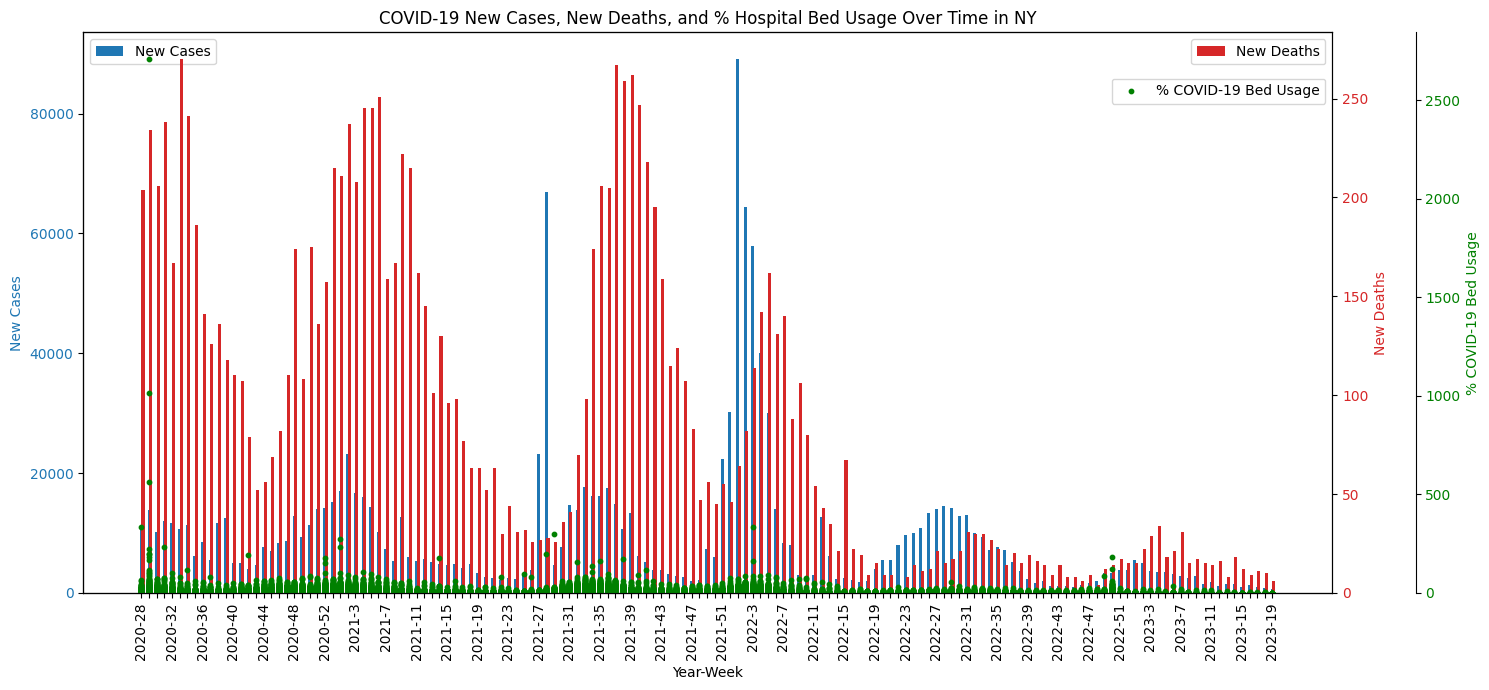

In [25]:
# Calculate the percentage of inpatient beds used for COVID-19 out of total beds
ny_data['covid_bed_usage_pct'] = (ny_data['inpatient_beds_used_covid_7_day_sum'] / ny_data['total_beds_7_day_sum']) * 100

# Create a new figure and subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 'New cases' on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('New Cases', color=color)
ax1.bar(ny_data['year_week'], ny_data['New cases'], color=color, label='New Cases', width=0.4, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'New deaths'
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('New Deaths', color=color)
ax2.bar(ny_data['year_week'], ny_data['New deaths'], color=color, label='New Deaths', width=0.4, align='edge')
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for hospital bed usage
ax3 = ax1.twinx()
# Offset the right spine of ax3. The ticks and label have already been
# placed on the right by twinx above.
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
color = 'green' 
ax3.set_ylabel('% COVID-19 Bed Usage', color=color)
ax3.scatter(ny_data['year_week'], ny_data['covid_bed_usage_pct'], color=color, label='% COVID-19 Bed Usage', s=10)  # Using scatter to plot dots
ax3.tick_params(axis='y', labelcolor=color)

# Set the title of the plot
plt.title('COVID-19 New Cases, New Deaths, and % Hospital Bed Usage Over Time in NY')

# Rotate the date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Adjust the ticks to show every Nth label to avoid clutter
for index, label in enumerate(ax1.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)

# Show the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right',bbox_to_anchor=(1, 0.93))

# Set the lower limit of the y-axes to 0 after plotting the data
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()

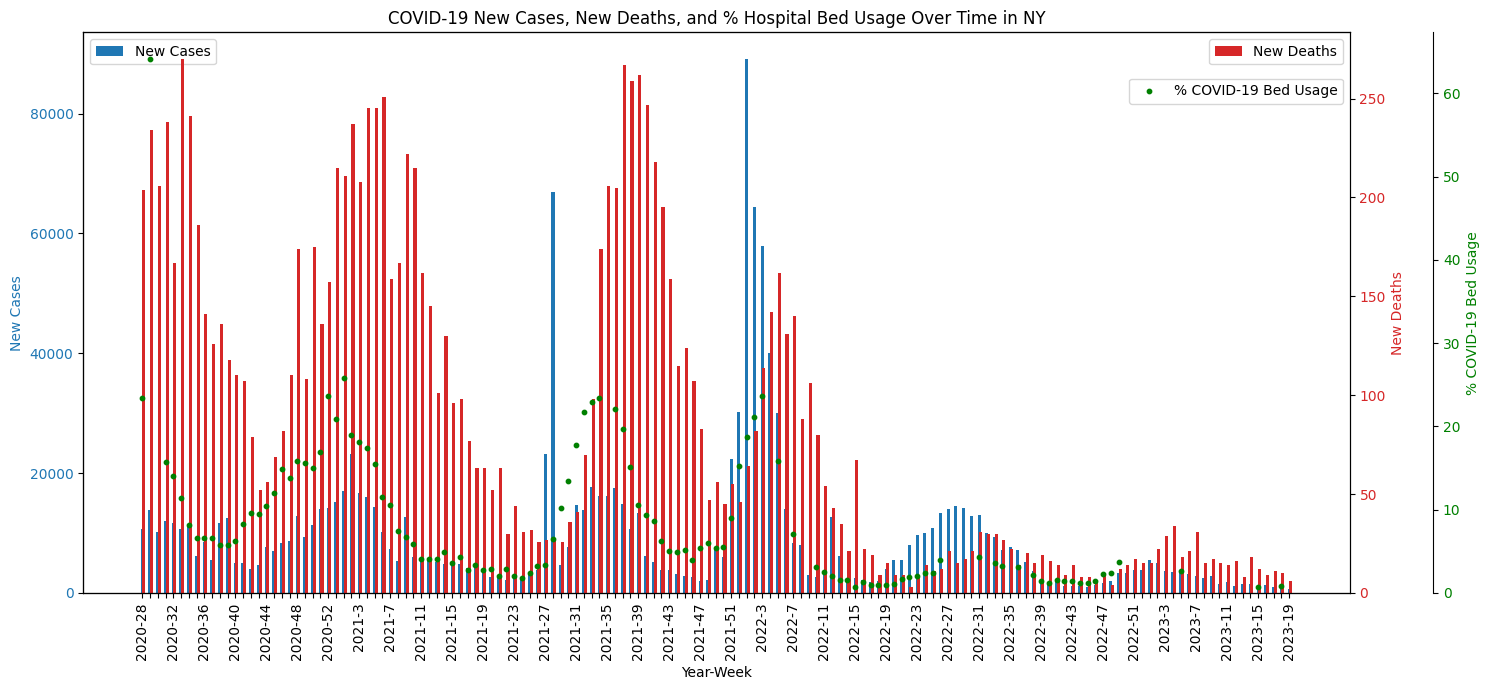

In [26]:
# Group the data by 'year_week' and calculate the mean percentage
average_bed_usage = ny_data.groupby('year_week')['covid_bed_usage_pct'].mean().reset_index()

# Create a new figure and subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 'New cases' on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('New Cases', color=color)
ax1.bar(ny_data['year_week'], ny_data['New cases'], color=color, label='New Cases', width=0.4, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'New deaths'
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('New Deaths', color=color)
ax2.bar(ny_data['year_week'], ny_data['New deaths'], color=color, label='New Deaths', width=0.4, align='edge')
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for hospital bed usage
ax3 = ax1.twinx()
# Offset the right spine of ax3. The ticks and label have already been
# placed on the right by twinx above.
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
color = 'green' 
ax3.set_ylabel('% COVID-19 Bed Usage', color=color)
# Use 'average_bed_usage' for plotting the percentage of COVID-19 bed usage
ax3.scatter(average_bed_usage['year_week'], average_bed_usage['covid_bed_usage_pct'], color=color, label='% COVID-19 Bed Usage', s=10)

ax3.tick_params(axis='y', labelcolor=color)

# Set the title of the plot
plt.title('COVID-19 New Cases, New Deaths, and % Hospital Bed Usage Over Time in NY')

# Rotate the date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Adjust the ticks to show every Nth label to avoid clutter
for index, label in enumerate(ax1.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)

# Show the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right',bbox_to_anchor=(1, 0.93))

# Set the lower limit of the y-axes to 0 after plotting the data
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()